In [969]:
from scipy.optimize import fsolve
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy import integrate
from scipy.integrate import solve_ivp
from scipy.interpolate import RectBivariateSpline
from astropy.io import ascii
from scipy.optimize import least_squares
from scipy.optimize import minimize
import scipy
from astropy import constants as const
from astropy import units as u

In [1312]:
#Table 74 from OPAL for solar composition X=0.7 Y = 0.27 Z=0.03
Mass = 1.35*(const.M_sun.cgs).value
comp_x, comp_y, comp_z = 0.7, 0.28, 0.02
Radius = const.R_sun.cgs.value
L_star = const.L_sun.cgs.value
T_eff = 5778
a = 7.567e-15

In [50]:
L_star

3.828e+33

In [274]:
#Code used from HW 3. Uses opal table 74, removes headers, then appended 0 

df = np.genfromtxt('TABLE#74_new.txt', skip_header=0)

log_T = df[1:,0]
log_R = df[0,1:]
op_vals = df[1:,1:]
#op_vals[op_vals==0]=['nan']

In [275]:
op_vals.shape[0]

57

In [32]:
#R parameter is density / (T6**3) where T6 = T * 1e-6 K
#log_R + Log(T6**3) = Log(density) 
#T6 = (10**log_T)/(1e6)
#rho = log_R + np.log10(T6**3)
#min(rho)


#log(T6**3) = log (Te-6 **3) = log(Te-18) = log(T)-18
#log_R = log(rho) - (log(T)-18)

In [276]:
interp_kappa = RectBivariateSpline(log_T, log_R, op_vals)

In [277]:
interp_kappa.ev(4,0)

array(2.069)

In [906]:
file_name = 'GN93hz.txt'
start_line = 242
table_row_length = 77
tables = {}

with open(file_name) as f:
    lines = f.readlines()

for i in range(126):
    table = {}
    title_items = lines[start_line + table_row_length * i - 1].split()

    table_name = f'Table {title_items[2]}'
    if i < 99:
        X = float(title_items[5].split('=')[1])
        Y = float(title_items[6].split('=')[1])
        Z = float(title_items[7].split('=')[1])
        dXc = float(title_items[8].split('=')[1])
        dXo = float(title_items[9].split('=')[1])
    else:
        X = float(title_items[4].split('=')[1])
        Y = float(title_items[5].split('=')[1])
        Z = float(title_items[6].split('=')[1])
        dXc = float(title_items[7].split('=')[1])
        dXo = float(title_items[8].split('=')[1])

    table['Composition'] = {'X': X, 'Y': Y, 'Z': Z, 'dXc': dXc, 'dXo': dXo}
    log_R_str = lines[start_line + table_row_length * i + 4 - 1].split()[1:]
    log_R = np.array([float(t) for t in log_R_str])
    table['log_R'] = log_R
    table_val = np.zeros((70, len(log_R)))
    log_T = []
    for j in range(70):
        line_to_process = lines[start_line + table_row_length * i + 5 + j].split()
        log_T.append(float(line_to_process[0]))
        val_str = lines[start_line + table_row_length * i + 5 + j].split()[1:]
        val = np.array([float(t) for t in val_str])
        table_val[j, 0:val.shape[0]] = val
    table['name'] = table_name
    table['log_T'] = np.array(log_T)
    table['val'] = table_val
    tables[table_name] = table

In [907]:
def get_opacity_table(X, Y, Z):
    for i, table_name in enumerate(tables.keys()):
        if tables[table_name]['Composition']['X'] == X and tables[table_name]['Composition']['Y'] == Y and tables[table_name]['Composition']['Z'] == Z:
            table = tables[table_name]
            break
        if i == len(tables.keys()) - 1:
            raise ('Not found')
    return table

In [1094]:
#These gave better table inputs to the interpolation idk why
table = get_opacity_table(comp_x, comp_y, comp_z)
opacity_interp = scipy.interpolate.RectBivariateSpline(table['log_T'], table['log_R'], table['val'])

In [1102]:
table

{'Composition': {'X': 0.7, 'Y': 0.28, 'Z': 0.02, 'dXc': 0.0, 'dXo': 0.0},
 'log_R': array([-8. , -7.5, -7. , -6.5, -6. , -5.5, -5. , -4.5, -4. , -3.5, -3. ,
        -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ]),
 'name': 'Table 73',
 'log_T': array([3.75, 3.8 , 3.85, 3.9 , 3.95, 4.  , 4.05, 4.1 , 4.15, 4.2 , 4.25,
        4.3 , 4.35, 4.4 , 4.45, 4.5 , 4.55, 4.6 , 4.65, 4.7 , 4.75, 4.8 ,
        4.85, 4.9 , 4.95, 5.  , 5.05, 5.1 , 5.15, 5.2 , 5.25, 5.3 , 5.35,
        5.4 , 5.45, 5.5 , 5.55, 5.6 , 5.65, 5.7 , 5.75, 5.8 , 5.85, 5.9 ,
        5.95, 6.  , 6.1 , 6.2 , 6.3 , 6.4 , 6.5 , 6.6 , 6.7 , 6.8 , 6.9 ,
        7.  , 7.1 , 7.2 , 7.3 , 7.4 , 7.5 , 7.6 , 7.7 , 7.8 , 7.9 , 8.  ,
        8.1 , 8.3 , 8.5 , 8.7 ]),
 'val': array([[-0.767, -0.928, -1.119, ..., -0.645, -0.261,  0.131],
        [-0.561, -0.598, -0.675, ..., -0.18 ,  0.121,  0.429],
        [-0.534, -0.53 , -0.525, ...,  0.384,  0.628,  0.894],
        ...,
        [-0.633, -0.633, -0.633, ...,  0.   ,  0.   ,  0.   ],
     

In [1095]:
opacity_interp


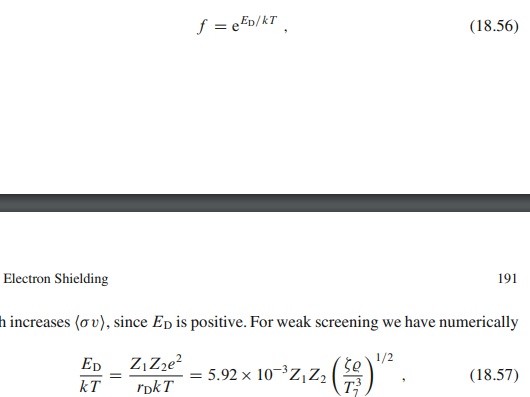
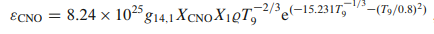


In [ ]:
'''
Z are 1 cuz nucleus of H. Zeta is 1 cuz textbook says so. Psi starts at 1 then reaches 2 around T7=2. Can be approximated as 1.5?


In [1505]:
'''
Energy generation rates for pp-chain and CNO cycle at core of sun like star based on equations above
'''

def energy_rates(density, temp, X, Z):
    T7 = temp/(1e7)
    T9 = temp/(1e9)
    
    #if density <0:
        #density=0
        
    #Weak screening factor
    f_ratio = (5.92e-3) * ((density/(T7**3))**0.5)
    screen_f = np.exp(f_ratio)
    
    #PP chain epsilon
    g11 = 1+ (3.82*T9) + (1.51* (T9**2)) + (0.144 *(T9**3)) - (0.0114 *(T9**4))
    e_pp = (2.57e4) * (1) * g11* screen_f * density * (X**2) * (T9**(-2/3)) * np.exp(-3.381/(T9**(1/3)))
    
    #CNO chain epsilon
    g14 = 1 - (2*T9) + (3.41*(T9**2)) - (2.43*(T9**3))
    e_cno = (8.24e25) * (0.7*Z) * X * g14* density * (T9**(-2/3)) * np.exp(-15.231*(T9**(-1/3)) - ((T9/0.8)**2) )
    
    #Final epsilon
    e_tot = e_pp + e_cno
    
    return e_tot
    

In [64]:
def calc_density(P,T,X):
    
    mu = 4 / (3 + (5*X))
    Prad = a * (T**4)/3
      
    density = (P - Prad) * (mu/ (T * const.k_B.cgs.value * const.N_A.cgs.value))
    return density

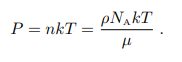

In [1304]:
def load1(Pc, Tc):
    
    m_cent = 1e-5*Mass
    rhoc = calc_density(Pc, Tc, comp_x)
    epsilon = energy_rates(rhoc,Tc,comp_x,comp_z)
    
    r0 = (3*m_cent/(4*np.pi*rhoc))**(1/3)
    l0 = epsilon * m_cent
    Pc2 = Pc - (3 * const.G.cgs.value / 8 / np.pi) * (4 * np.pi * rhoc / 3)**(4/3) * (m_cent**(2/3))
    #Pc = (2.477e11 *u.bar).cgs.value
    #Tc = 1.571e7
    return [r0, l0, Pc2, Tc]

def load2(rf, lf):
    kappa = 0.32
    #rf = Radius
    #lf = L_star
    Pf = (const.G.cgs.value * Mass / (rf**2)) * (2/3) *(1/kappa)
    #Pf = 0
    Tf = (lf / (4*np.pi * (rf**2) * const.sigma_sb.cgs.value))**(1/4)
    return [rf,lf,Pf,Tf]

In [231]:
nabla_ad = 0.4
def nabla_rad(m,P,l,T,kappa):
    nabla_rad = (3/(64*np.pi*const.sigma_sb.cgs.value * const.G.cgs.value)) * (kappa*P*l)/(m * (T**4)) 
    return nabla_rad

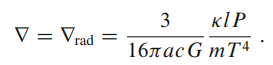

In [1103]:
def derivs(m,int_vals):
    
    r,l,P,T = int_vals
    rho = calc_density(P,T,comp_x)
    epsilon = energy_rates(rho,T,comp_x,comp_z)
    
    logT = np.log10(T)
    if logT > 8.7:
        logT = 8.7
    if logT < 3.75:
        logT = 3.75
        
    R = rho / ((T*1e-6)**3)
    logR = np.log10(R)
    
    if logR > 1.0:
        logR = 1.0
    if logR < -8.0:
        logR = -8.0
        
    kappa = 10**(opacity_interp(logT,logR))
    
    nabla_ad = 0.4
    nabla_rad = (3/(64*np.pi*const.sigma_sb.cgs.value*const.G.cgs.value)) * (kappa*P*l)/(m * (T**4))
    chosen_nabla = min(nabla_ad, nabla_rad)
    
    
    dP_dm = -1*(const.G.cgs.value * m) / (4*np.pi* (r**4))
    dl_dm = epsilon
    dr_dm = 1/(4*np.pi*(r**2) * rho)
    dT_dm = -1*(const.G.cgs.value*m*T)/(4*np.pi*(r**4)*P) * chosen_nabla
    
    return [dr_dm, dl_dm, dP_dm, dT_dm]

In [1305]:
def shootf(params):
    
    m_cent = 1e-5*Mass
    m_surf = Mass
    m_mid = Mass/2
    
    center_vals = load1(params[2],params[3])
    surf_vals = load2(params[0], params[1])
    #print(center_vals)
    m_cent_steps = np.linspace(m_cent, m_mid, 2000)
    m_surf_steps = np.linspace(m_surf, m_mid, 2000)
    #print(m_surf_steps)
    sol_center = solve_ivp(derivs, [m_cent,m_mid], center_vals, t_eval=m_cent_steps, method='RK45')
    
    
    sol_surf = solve_ivp(derivs, [m_surf,m_mid], surf_vals, t_eval = m_surf_steps, method='RK45')
    
    #print(sol_surf.t)
    
    return sol_center.y, sol_surf.y, sol_center.t, sol_surf.t

In [1441]:
#Test shootf function with scaled guesses --- one model with no optimization
guess = [Radius, L_star, 1.92e17, 1.571e7]
guess = np.array(guess)
params_scaled_guess=[1.4,2.8,1,1]
params_scaled_guess = np.array(params_scaled_guess)

cent, out, cent_mass, out_mass = shootf(params_scaled_guess * guess)

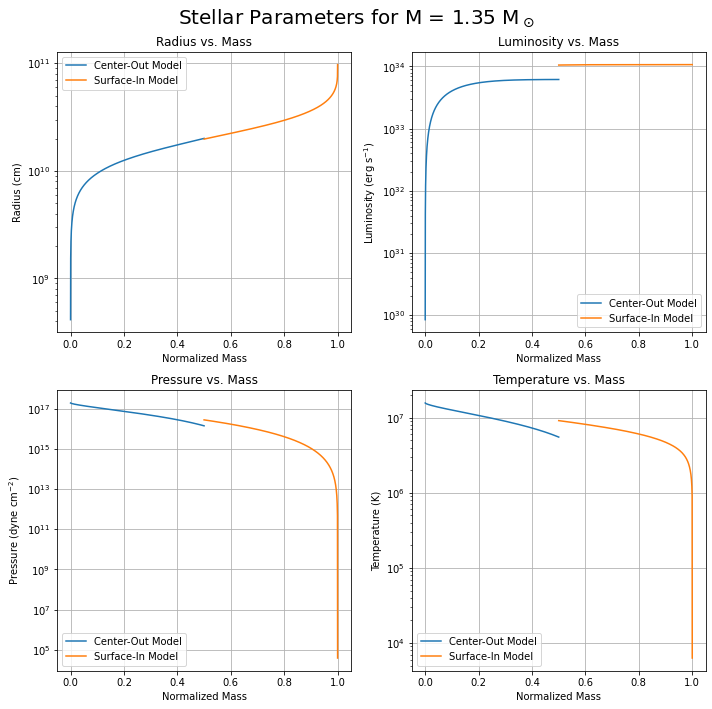

In [1483]:
fig, ax = plt.subplots(2, 2, figsize = (10,10))
    
ax[0,0].plot(cent_mass/Mass,cent[0,:],label= 'Center-Out Model')
ax[0,0].plot(out_mass/Mass,out[0,:], label = 'Surface-In Model')
ax[0,0].set_title('Radius vs. Mass')
ax[0,0].set_yscale('log')
ax[0,0].set_ylabel('Radius (cm)')
ax[0,0].set_xlabel('Normalized Mass')
ax[0,0].legend()
ax[0,0].grid()


ax[0,1].plot(cent_mass/Mass,cent[1,:],label= 'Center-Out Model')
ax[0,1].plot(out_mass/Mass,out[1,:], label = 'Surface-In Model')
ax[0,1].set_title('Luminosity vs. Mass')
ax[0,1].set_yscale('log')
ax[0,1].set_ylabel('Luminosity (erg s$^{-1}$)')
ax[0,1].set_xlabel('Normalized Mass')
ax[0,1].legend()
ax[0,1].grid()


ax[1,0].plot(cent_mass/Mass,cent[2,:],label= 'Center-Out Model')
ax[1,0].plot(out_mass/Mass,out[2,:], label = 'Surface-In Model')
ax[1,0].set_title('Pressure vs. Mass')
ax[1,0].set_yscale('log')
ax[1,0].set_ylabel('Pressure (dyne cm$^{-2}$)')
ax[1,0].set_xlabel('Normalized Mass')
ax[1,0].legend()
ax[1,0].grid()


ax[1,1].plot(cent_mass/Mass,cent[3,:],label= 'Center-Out Model')
ax[1,1].plot(out_mass/Mass,out[3,:], label = 'Surface-In Model')
ax[1,1].set_title('Temperature vs. Mass')
ax[1,1].set_yscale('log')
ax[1,1].set_ylabel('Temperature (K)')
ax[1,1].set_xlabel('Normalized Mass')
ax[1,1].legend()
ax[1,1].grid()


fig.suptitle('Stellar Parameters for M = 1.35 M$_\odot$', fontsize=20)
fig.tight_layout()
#fig.savefig('Initial_plots.png')

In [1443]:
#Objective function (Chi-squared) to be minimized by scipy least_squares
def mid_pt_diff(params_scaled, guess):
    scaled_variables = params_scaled * guess
    in_data, out_data, in_mass, out_mass = shootf(scaled_variables)
    
    #Percent difference (midpoint difference divided by scale or full width of data)
    perc_diff = (in_data[:,-1] - out_data[:,-1]) / (in_data[:,0]- out_data[:,0])
    
    mid_points = np.sum(perc_diff**2)
    return (mid_points) 

In [1391]:
#Use least_squares to minimize midpoint difference by iterating shootf function with different initial parameters (Rf, Lf, Pc, Tc)
#Initial guesses scaled from solar mass values

guess = [Radius, L_star, 1.92e17, 1.571e7]

params_scaled_guess=[1.45,2.85,0.95,1]

boundaries = ([0.1,0.1,0.1,0.1], [3,4,2,2])

result = least_squares(mid_pt_diff,params_scaled_guess, bounds=boundaries, args=([guess]),loss='soft_l1', verbose=2)
optimized= result.x

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.7289e-03                                    4.78e-01    
       1              2         1.0843e-03      6.64e-03       2.99e-02       6.43e-02    
       2              3         5.6238e-04      5.22e-04       3.17e-02       2.04e-02    
       3              5         3.9456e-04      1.68e-04       1.02e-02       1.08e-02    
       4              6         2.9987e-04      9.47e-05       1.04e-02       7.60e-03    
       5              7         1.5537e-04      1.45e-04       2.05e-02       7.89e-03    
       6              9         1.0229e-04      5.31e-05       1.02e-02       3.99e-03    
       7             10         3.9931e-05      6.24e-05       2.02e-02       4.23e-03    
       8             12         1.8206e-05      2.17e-05       1.01e-02       1.78e-03    
       9             13         7.0615e-06      1.11e-05       9.96e-03       1.31e-03    

In [1397]:
#Optimized in 21 iterations, found global minimum by changing initial guess to avoid local minima
optimized

array([1.42956518, 2.80732524, 1.02763597, 1.08303519])

In [1446]:
#Final optimized (Rf, Lf, Pc, Tc)
final_params = optimized*guess
final_params

array([9.94548495e+10, 1.07464410e+34, 1.97306107e+17, 1.70144829e+07])

In [1439]:
#Call shootf with optimized parameters to generate optimal stellar model
cent2, out2, cent_mass, out_mass = shootf(optimized*guess)

In [1500]:
reversed_out2 = out2[:,::-1]
np.shape(reversed_out2[0,:])

(2000,)

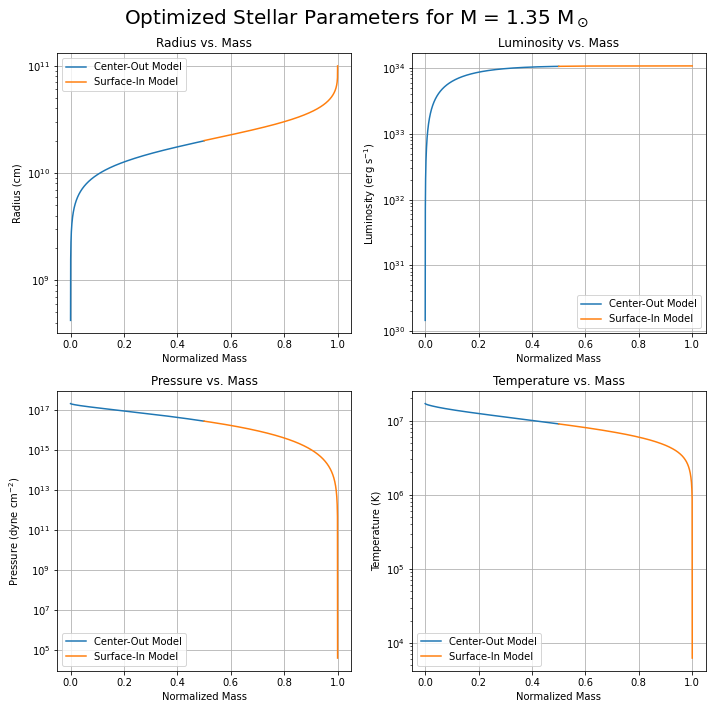

In [1482]:
fig, ax = plt.subplots(2, 2, figsize = (10,10))
    
ax[0,0].plot(cent_mass/Mass,cent2[0,:],label= 'Center-Out Model')
ax[0,0].plot(out_mass/Mass,out2[0,:], label = 'Surface-In Model')
ax[0,0].set_title('Radius vs. Mass')
ax[0,0].set_yscale('log')
ax[0,0].set_ylabel('Radius (cm)')
ax[0,0].set_xlabel('Normalized Mass')
ax[0,0].legend()
ax[0,0].grid()


ax[0,1].plot(cent_mass/Mass,cent2[1,:],label= 'Center-Out Model')
ax[0,1].plot(out_mass/Mass,out2[1,:], label = 'Surface-In Model')
ax[0,1].set_title('Luminosity vs. Mass')
ax[0,1].set_yscale('log')
ax[0,1].set_ylabel('Luminosity (erg s$^{-1}$)')
ax[0,1].set_xlabel('Normalized Mass')
ax[0,1].legend()
ax[0,1].grid()


ax[1,0].plot(cent_mass/Mass,cent2[2,:],label= 'Center-Out Model')
ax[1,0].plot(out_mass/Mass,out2[2,:], label = 'Surface-In Model')
ax[1,0].set_title('Pressure vs. Mass')
ax[1,0].set_yscale('log')
ax[1,0].set_ylabel('Pressure (dyne cm$^{-2}$)')
ax[1,0].set_xlabel('Normalized Mass')
ax[1,0].legend()
ax[1,0].grid()


ax[1,1].plot(cent_mass/Mass,cent2[3,:],label= 'Center-Out Model')
ax[1,1].plot(out_mass/Mass,out2[3,:], label = 'Surface-In Model')
ax[1,1].set_title('Temperature vs. Mass')
ax[1,1].set_yscale('log')
ax[1,1].set_ylabel('Temperature (K)')
ax[1,1].set_xlabel('Normalized Mass')
ax[1,1].legend()
ax[1,1].grid()


fig.suptitle('Optimized Stellar Parameters for M = 1.35 M$_\odot$', fontsize=20)
fig.tight_layout()
fig.savefig('Optimized_plots.png')

In [1489]:
df = pd.read_csv('history.data', sep="\s+", header=4)
df.columns

Index(['model_number', 'num_zones', 'star_age', 'log_dt', 'star_mass',
       'log_xmstar', 'log_abs_mdot', 'mass_conv_core', 'conv_mx1_top',
       'conv_mx1_bot', 'conv_mx2_top', 'conv_mx2_bot', 'mx1_top', 'mx1_bot',
       'mx2_top', 'mx2_bot', 'log_LH', 'log_LHe', 'log_LZ', 'log_Lnuc', 'pp',
       'cno', 'tri_alpha', 'epsnuc_M_1', 'epsnuc_M_2', 'epsnuc_M_3',
       'epsnuc_M_4', 'epsnuc_M_5', 'epsnuc_M_6', 'epsnuc_M_7', 'epsnuc_M_8',
       'he_core_mass', 'co_core_mass', 'one_core_mass', 'fe_core_mass',
       'neutron_rich_core_mass', 'log_Teff', 'log_L', 'log_R', 'log_g',
       'v_div_csound_surf', 'log_cntr_P', 'log_cntr_Rho', 'log_cntr_T',
       'center_mu', 'center_ye', 'center_abar', 'center_h1', 'center_he4',
       'center_c12', 'center_o16', 'surface_c12', 'surface_o16',
       'total_mass_h1', 'total_mass_he4', 'num_retries', 'num_iters'],
      dtype='object')

In [1490]:
logP = 10** np.array(df['log_cntr_P'].tail(1))
logT = 10 **np.array (df['log_cntr_T'].tail(1))
logR =10 **np.array( df['log_R'].tail(1))
logL =10** np.array( df['log_L'].tail(1))

In [1491]:
logR

array([1.32115524])

In [1492]:
mesa_final_params = np.array([logR[0]*Radius, logL[0]*L_star, logP[0], logT[0]])
mesa_final_params

array([9.19127700e+10, 1.07792612e+34, 1.92598654e+17, 1.69039118e+07])

In [1452]:
perc_diff = 100 *(final_params - mesa_final_params)/ mesa_final_params
print(f'Percent difference between MESA stellar paramenters and optimized model for R, L, Pc, and Tc are {perc_diff[0]:.2f}%, {perc_diff[1]:.2f}%, {perc_diff[2]:.2f}%, {perc_diff[3]:.2f}%')

Percent difference between MESA stellar paramenters and optimized model for R, L, Pc, and Tc are 8.21%, -0.30%, 2.44%, 0.65%


In [1461]:
df = pd.read_csv('profile5.data', sep="\s+", header=4)
df.columns

Index(['zone', 'mass', 'logR', 'logT', 'logRho', 'logP', 'x_mass_fraction_H',
       'y_mass_fraction_He', 'z_mass_fraction_metals', 'pp', 'cno',
       'tri_alpha'],
      dtype='object')

In [1475]:
m_mesa = df['mass']
r_mesa = np.power(10, df['logR'])
t_mesa = np.power(10, df['logT'])
p_mesa = np.power(10, df['logP'])
rho_mesa = np.power(10, df['logRho'])


In [1471]:
rho_profile1 = calc_density(cent2[2,:],cent2[3,:],comp_x)
rho_profile2 = calc_density(out2[2,:],out2[3,:],comp_x)

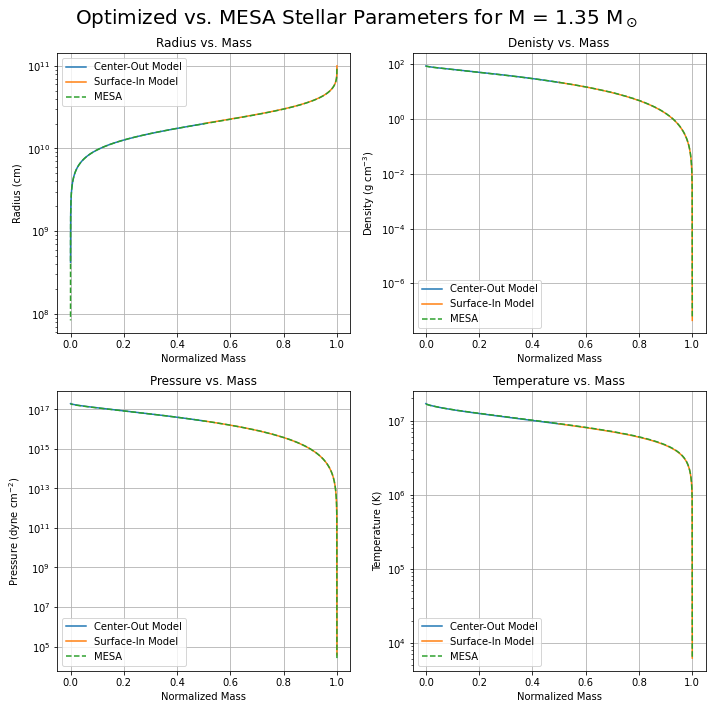

In [1487]:
fig, ax = plt.subplots(2, 2, figsize = (10,10))
    
ax[0,0].plot(cent_mass/Mass,cent2[0,:],label= 'Center-Out Model')
ax[0,0].plot(out_mass/Mass,out2[0,:], label = 'Surface-In Model')
ax[0,0].plot(m_mesa/1.33,r_mesa*Radius, label = 'MESA',linestyle='--')
ax[0,0].set_title('Radius vs. Mass')
ax[0,0].set_yscale('log')
ax[0,0].set_ylabel('Radius (cm)')
ax[0,0].set_xlabel('Normalized Mass')
ax[0,0].legend()
ax[0,0].grid()

ax[0,1].plot(cent_mass/Mass,rho_profile1,label= 'Center-Out Model')
ax[0,1].plot(out_mass/Mass,rho_profile2, label = 'Surface-In Model')
ax[0,1].plot(m_mesa/1.33,rho_mesa, label = 'MESA',linestyle='--')
ax[0,1].set_title('Denisty vs. Mass')
ax[0,1].set_yscale('log')
ax[0,1].set_ylabel('Density (g cm$^{-3}$)')
ax[0,1].set_xlabel('Normalized Mass')
ax[0,1].legend()
ax[0,1].grid()

ax[1,0].plot(cent_mass/Mass,cent2[2,:],label= 'Center-Out Model')
ax[1,0].plot(out_mass/Mass,out2[2,:], label = 'Surface-In Model')
ax[1,0].plot(m_mesa/1.33,p_mesa, label = 'MESA',linestyle='--')
ax[1,0].set_title('Pressure vs. Mass')
ax[1,0].set_yscale('log')
ax[1,0].set_ylabel('Pressure (dyne cm$^{-2}$)')
ax[1,0].set_xlabel('Normalized Mass')
ax[1,0].legend()
ax[1,0].grid()

ax[1,1].plot(cent_mass/Mass,cent2[3,:],label= 'Center-Out Model')
ax[1,1].plot(out_mass/Mass,out2[3,:], label = 'Surface-In Model')
ax[1,1].plot(m_mesa/1.33,t_mesa, label = 'MESA', linestyle='--')
ax[1,1].set_title('Temperature vs. Mass')
ax[1,1].set_yscale('log')
ax[1,1].set_ylabel('Temperature (K)')
ax[1,1].set_xlabel('Normalized Mass')
ax[1,1].legend()
ax[1,1].grid()


fig.suptitle('Optimized vs. MESA Stellar Parameters for M = 1.35 M$_\odot$', fontsize=20)
fig.tight_layout()
fig.savefig('Mesa_plots.png')

In [1533]:
def gen_data_table(params):
    cent2, out2, cent_mass, out_mass = shootf(params)
    
    reversed_out2 = out2[:,::-1]
    reversed_out_mass = out_mass[::-1]
    
    rval = np.concatenate((cent2[0,:],reversed_out2[0,:]))
    lval = np.concatenate((cent2[1,:],reversed_out2[1,:]))
    Pval = np.concatenate((cent2[2,:],reversed_out2[2,:]))
    Tval = np.concatenate((cent2[3,:],reversed_out2[3,:]))
    mval = np.concatenate((cent_mass,reversed_out_mass))
    
    rho_val = calc_density(Pval,Tval,comp_x)
    epsilon_val = energy_rates(rho_val,Tval,comp_x,comp_z)
    
    logT = np.log10(Tval)
        
    R = rho_val / ((Tval*1e-6)**3)
    logR = np.log10(R)
    
    nabla_val=[]
    conv_status=[]
    for i in range(len(logT)):
        
        kappa_val = 10**(opacity_interp(logT[i],logR[i]))

        nabla_ad = 0.4
        nabla_rad = (3/(64*np.pi*const.sigma_sb.cgs.value*const.G.cgs.value)) * (kappa_val*Pval[i]*lval[i])/(mval[i] * (Tval[i]**4))
        nabla_rad = nabla_rad[0]
        nabla_val.append(min(nabla_ad, nabla_rad))
        
        if nabla_ad > nabla_rad:
            conv_status.append(0)
        else:
            conv_status.append(1)
        
    
    return [mval, rval, lval, Pval, Tval, rho_val, epsilon_val, nabla_val, conv_status]

In [1534]:
data = gen_data_table(final_params)
np.shape(data)

C:\Users\jackf\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(9, 4000)

In [1535]:
headers = ['m', 'r', 'l', 'P', 'T', 'rho', 'epsilon', 'nabla', 'convective_status']
df = pd.DataFrame(np.transpose(data), columns = headers)

C:\Users\jackf\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [1536]:
df

,m,r,l,P,T,rho,epsilon,nabla,convective_status
0,26843533254423694704126197760.0,421237921.491241,1454766332419445032154084409344.0,197123777644208736.0,17014482.893399,85.657765,54.143762,0.4,1
1,698254148155839482619525857280.0,1249348990.708817,37177546002507126856011074240512.0,195711445214874336.0,16965616.047276,85.289404,52.51156,0.4,1
2,1369664763057255323311483650048.0,1564283528.726352,72084181919862924957419000823808.0,194814538737059104.0,16934471.689935,85.054928,51.505837,0.4,1
3,2041075377958671023265953087488.0,1787439265.265822,106379095223814483653226829709312.0,194057430732087424.0,16908115.157776,84.856659,50.675002,0.4,1
4,2712485992860087286170375946240.0,1965717979.315595,140153883729439611153990635487232.0,193386584604252768.0,16884707.549803,84.680733,49.952328,0.4,1
...,...,...,...,...,...,...,...,...,...
3995,2681667629268840115785825976844288.0,73562313409.902039,10746441000370644198009008889528320.0,1044542104405.509277,1075043.1455,0.007168,0.0,[0.21902899916583285],0
3996,2682339053312222101050691166404608.0,75108244085.649948,10746441000370662644753082599079936.0,730673076852.644775,994887.280198,0.005417,0.0,[0.2164326682296682],0
3997,2683010477355604662776308659388416.0,77163444977.969833,10746441000370667256439101026467840.0,444935346131.33551,895709.440263,0.003663,0.0,[0.2088765443174428],0
3998,2683681901398986648041173848948736.0,80370770493.811264,10746441000370667256439101026467840.0,194056758812.546753,755048.910753,0.001894,0.0,[0.20578460041227634],0


In [1537]:
df.to_csv('Stellar_structure_table.csv', index=False)